# Advanced RAG: Query Expansion
_by Tuana Celik ([LI](https://www.linkedin.com/in/tuanacelik/),  [Twitter/X](https://x.com/tuanacelik))_

> This is part one of the **Advanced Use Cases** series:
>
> 1️⃣ Extract Metadata from Queries to Improve Retrieval [cookbook](/cookbook/extracting_metadata_filters_from_a_user_query) & [full article](/blog/extracting-metadata-filter)
>
> 2️⃣ **Query Expansion & the [full article](/blog/query-expansion)**
>
> 3️⃣ Query Decomposition [cookbook](/cookbook/query_decomposition) & [full article](/blog/query-decomposition)
>
> 4️⃣ [Automated Metadata Enrichment](/cookbook/metadata_enrichment)

In this cookbook, you'll learn how to implement query expansion for RAG. Query expansion consists of asking an LLM to produce a number of similar queries to a user query. We are then able to use each of these queries in the retrieval process, increasing the number and relevance of retrieved documents.

📚 [Read the full article](https://haystack.deepset.ai/blog/query-expansion)

In [ ]:
!pip install haystack-ai wikipedia

In [4]:
import wikipedia
import json

from typing import List, Optional
from haystack import Pipeline, component

from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.retrievers import InMemoryBM25Retriever
from haystack.components.writers import DocumentWriter

from haystack.dataclasses import Document

from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

In [3]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
  os.environ['OPENAI_API_KEY'] = getpass("Your OpenAI API Key: ")

## The Process of Query Expansion

First, let's create a `QueryExpander`. This component is going to be able to create a `number` (defaults to 5) of additional queries, similar to the original user query. It returns `queries` that has the original query + `number` of similar queries.

In [5]:
@component
class QueryExpander:

    def __init__(self, prompt: Optional[str] = None, model: str = "gpt-4o-mini"):

        self.query_expansion_prompt = prompt
        self.model = model
        if prompt == None:
          self.query_expansion_prompt = """
          You are part of an information system that processes users queries.
          You expand a given query into {{ number }} queries that are similar in meaning.
          
          Structure:
          Follow the structure shown below in examples to generate expanded queries.
          Examples:
          1. Example Query 1: "climate change effects"
          Example Expanded Queries: ["impact of climate change", "consequences of global warming", "effects of environmental changes"]
          
          2. Example Query 2: ""machine learning algorithms""
          Example Expanded Queries: ["neural networks", "clustering", "supervised learning", "deep learning"]
          
          Your Task:
          Query: "{{query}}"
          Example Expanded Queries:
          """
        builder = PromptBuilder(self.query_expansion_prompt)
        llm = OpenAIGenerator(model = self.model)
        self.pipeline = Pipeline()
        self.pipeline.add_component(name="builder", instance=builder)
        self.pipeline.add_component(name="llm", instance=llm)
        self.pipeline.connect("builder", "llm")

    @component.output_types(queries=List[str])
    def run(self, query: str, number: int = 5):
        result = self.pipeline.run({'builder': {'query': query, 'number': number}})
        expanded_query = json.loads(result['llm']['replies'][0]) + [query]
        return {"queries": list(expanded_query)}

In [6]:
expander = QueryExpander()
expander.run(query="open source nlp frameworks", number=4)

{'queries': ['natural language processing tools',
  'free nlp libraries',
  'open-source language processing software',
  'nlp frameworks with open licensing',
  'open source nlp frameworks']}

## Retrieval Without Query Expansion

In [5]:
documents = [
    Document(content="The effects of climate are many including loss of biodiversity"),
    Document(content="The impact of climate change is evident in the melting of the polar ice caps."),
    Document(content="Consequences of global warming include the rise in sea levels."),
    Document(content="One of the effects of environmental changes is the change in weather patterns."),
    Document(content="There is a global call to reduce the amount of air travel people take."),
    Document(content="Air travel is one of the core contributors to climate change."),
    Document(content="Expect warm climates in Turkey during the summer period."),
]

doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")
doc_store.write_documents(documents)

retriever = InMemoryBM25Retriever(document_store=doc_store, top_k=3)

retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("keyword_retriever", retriever)

In [10]:
query = "climate change"
retrieval_pipeline.run({"keyword_retriever":{ "query": query, "top_k": 3}})

{'keyword_retriever': {'documents': [Document(id=8b306c8303c59508a53e5139b4e688c3817fa0211b095bcc77ab3823defa0b32, content: 'Air travel is one of the core contributors to climate change.', score: 2.023895027544814),
   Document(id=aa996058ca5b30d8b469d33e992e094058e707bfb0cf057ee1d5b55ac4320234, content: 'The impact of climate change is evident in the melting of the polar ice caps.', score: 1.8661960327485192),
   Document(id=4d5f7ef8df12c93cb5728cc0247bf95282a14017ce9d0b35486091f8972347a5, content: 'The effects of climate are many including loss of biodiversity', score: 1.5532314806726806)]}}

## Retrieval With Query Expansion

Now let's have a look at what documents we are able to retrieve if we are to inluce query expansion in the process. For this step, let's create a `MultiQueryInMemoryBM25Retriever` that is able to use BM25 retrieval for each (expansded) query in turn.

This component also handles the same document being retrieved for multiple queries and will not return duplicates.

In [5]:
@component
class MultiQueryInMemoryBM25Retriever:

    def __init__(self, retriever: InMemoryBM25Retriever, top_k: int = 3):

        self.retriever = retriever
        self.results = []
        self.ids = set()
        self.top_k = top_k

    def add_document(self, document: Document):
        if document.id not in self.ids:
            self.results.append(document)
            self.ids.add(document.id)

    @component.output_types(documents=List[Document])
    def run(self, queries: List[str], top_k: int = None):
        if top_k != None:
          self.top_k = top_k
        for query in queries:
          result = self.retriever.run(query = query, top_k = self.top_k)
          for doc in result['documents']:
            self.add_document(doc)
        self.results.sort(key=lambda x: x.score, reverse=True)
        return {"documents": self.results}

In [13]:
query_expander = QueryExpander()
retriever = MultiQueryInMemoryBM25Retriever(InMemoryBM25Retriever(document_store=doc_store))

expanded_retrieval_pipeline = Pipeline()
expanded_retrieval_pipeline.add_component("expander", query_expander)
expanded_retrieval_pipeline.add_component("keyword_retriever", retriever)

expanded_retrieval_pipeline.connect("expander.queries", "keyword_retriever.queries")

🚅 Components
  - expander: QueryExpander
  - keyword_retriever: MultiQueryInMemoryBM25Retriever
🛤️ Connections
  - expander.queries -> keyword_retriever.queries (List[str])

In [15]:
expanded_retrieval_pipeline.run({"expander": {"query": query}}, include_outputs_from=["expander"])

{'keyword_retriever': {'documents': [Document(id=0901b034998c7263f74ac60cad5d9d520df524e59b045f3afab8e6cf1710791d, content: 'Consequences of global warming include the rise in sea levels.', score: 4.284392003065215),
   Document(id=aa996058ca5b30d8b469d33e992e094058e707bfb0cf057ee1d5b55ac4320234, content: 'The impact of climate change is evident in the melting of the polar ice caps.', score: 3.9819402104550026),
   Document(id=40fcd5a4a3670b7e105db664783c076167bb699cade9aa7fd6d409fac2efb49e, content: 'There is a global call to reduce the amount of air travel people take.', score: 3.4560290926489516),
   Document(id=4d5f7ef8df12c93cb5728cc0247bf95282a14017ce9d0b35486091f8972347a5, content: 'The effects of climate are many including loss of biodiversity', score: 3.2316583763625335),
   Document(id=395d2da61fff546098eec2838da741033d71fef84dfa7a91fc40b1d275631933, content: 'One of the effects of environmental changes is the change in weather patterns.', score: 3.136763077795208),
   Docume

## Query Expansion for RAG

Let's start off by populating a document store with chunks of context from various Wikipedia pages.

In [7]:
def get_doc_store():
    raw_docs = []
    wikipedia_page_titles = ["Electric_vehicle", "Dam", "Electric_battery", "Tree", "Solar_panel", "Nuclear_power",
                             "Wind_power", "Hydroelectricity", "Coal", "Natural_gas", "Greenhouse_gas", "Renewable_energy",
                             "Fossil_fuel"]
    for title in wikipedia_page_titles:
        page = wikipedia.page(title=title, auto_suggest=False)
        doc = Document(content=page.content, meta={"title": page.title, "url": page.url})
        raw_docs.append(doc)

    doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

    indexing_pipeline = Pipeline()
    indexing_pipeline.add_component("cleaner", DocumentCleaner())
    indexing_pipeline.add_component("splitter", DocumentSplitter(split_by="passage", split_length=1))
    indexing_pipeline.add_component("writer", DocumentWriter(document_store=doc_store, policy=DuplicatePolicy.SKIP))
    indexing_pipeline.connect("cleaner", "splitter")
    indexing_pipeline.connect("splitter", "writer")

    indexing_pipeline.run({"cleaner": {"documents": raw_docs}})

    return doc_store

In [8]:
doc_store = get_doc_store()

### RAG without Query Expansion

In [20]:
template = """
You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.
You build the summary answer based only on quoting information from the documents.
You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
retriever = InMemoryBM25Retriever(document_store=doc_store)
prompt_builder = PromptBuilder(template = template)
llm = OpenAIGenerator()

keyword_rag_pipeline = Pipeline()
keyword_rag_pipeline.add_component("keyword_retriever", retriever)
keyword_rag_pipeline.add_component("prompt", prompt_builder)
keyword_rag_pipeline.add_component("llm", llm)

keyword_rag_pipeline.connect("keyword_retriever.documents", "prompt.documents")
keyword_rag_pipeline.connect("prompt", "llm")

🚅 Components
  - keyword_retriever: InMemoryBM25Retriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - keyword_retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [21]:
keyword_rag_pipeline.run({"query": "green energy sources", "top_k": 3}, include_outputs_from=["keyword_retriever"])

{'llm': {'replies': ['Green energy sources refer to energy derived from renewable natural resources that are replenished over time. Wind power, specifically, is a type of green energy that harnesses wind energy to generate useful work. These sources contrast with fossil fuels like coal, oil, and natural gas, which are not considered green energy due to their carbon content. (Sources: Renewable energy - Wikipedia, Wind power - Wikipedia)'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 79,
     'prompt_tokens': 587,
     'total_tokens': 666}}]},
 'keyword_retriever': {'documents': [Document(id=d32ea84eda93bcbfc7ad39ad411f598a4a27a96a14ff6dc6a5415b6b86cb6f1e, content: 'Renewable energy (or green energy) is energy from renewable natural resources that are replenished o...', meta: {'title': 'Renewable energy', 'url': 'https://en.wikipedia.org/wiki/Renewable_energy', 'source_id': 'a1b15f8e8f7483541939c347ea2a59

### RAG with Query Expansion

In [9]:
template = """
You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.
You build the summary answer based only on quoting information from the documents.
You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
query_expander = QueryExpander()
retriever = MultiQueryInMemoryBM25Retriever(InMemoryBM25Retriever(document_store=doc_store))
prompt_builder = PromptBuilder(template = template)
llm = OpenAIGenerator()

query_expanded_rag_pipeline = Pipeline()
query_expanded_rag_pipeline.add_component("expander", query_expander)
query_expanded_rag_pipeline.add_component("keyword_retriever", retriever)
query_expanded_rag_pipeline.add_component("prompt", prompt_builder)
query_expanded_rag_pipeline.add_component("llm", llm)

query_expanded_rag_pipeline.connect("expander.queries", "keyword_retriever.queries")
query_expanded_rag_pipeline.connect("keyword_retriever.documents", "prompt.documents")
query_expanded_rag_pipeline.connect("prompt", "llm")

🚅 Components
  - expander: QueryExpander
  - keyword_retriever: MultiQueryInMemoryBM25Retriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - expander.queries -> keyword_retriever.queries (List[str])
  - keyword_retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

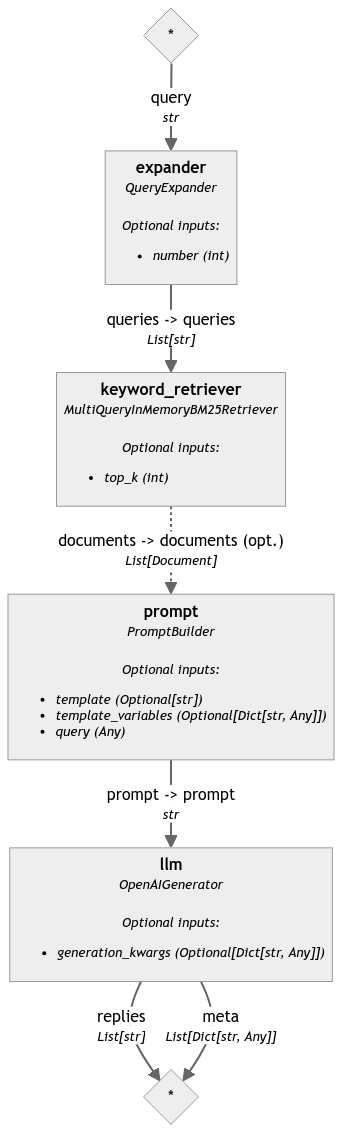

In [10]:
query_expanded_rag_pipeline.show()

In [23]:
query_expanded_rag_pipeline.run({"query": "green energy sources", "top_k": 3}, include_outputs_from=["keyword_retriever", "expander"])

{'llm': {'replies': ['Green energy sources refer to renewable energy from natural resources like wind power and electric vehicles that use electric motors for propulsion. This type of energy is sustainable and replenished over time, unlike fossil fuels or nuclear power. [Source: Wikipedia]'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 47,
     'prompt_tokens': 1242,
     'total_tokens': 1289}}]},
 'expander': {'queries': ['renewable energy sources',
   'sustainable energy options',
   'alternative energy sources',
   'environmentally friendly energy sources',
   'clean energy alternatives',
   'green energy sources']},
 'keyword_retriever': {'documents': [Document(id=03a55d98ad5f0fa8f849dd179913f9ffc25c9aad8aa11722a79df915356b1113, content: 'An electric battery is a source of electric power consisting of one or more electrochemical cells wi...', meta: {'title': 'Electric battery', 'url': 'https://en.wik